# Position-switched Data Reduction
----------------------------------

This notebook shows how to use `dysh` to calibrate an OnOff observation.
It retrieves and calibrates position-switch scans using `GBTFITSLoad.getps()`, which returns a `ScanBlock` object.  OffOn observations can be reduced the same way.

In [1]:
import astropy.units as u
from dysh.util.data import get_example_data
from dysh.fits.gbtfitsload import GBTFITSLoad

## Data Retrieval

First, we download the example SDFITS data, if necessary.

In [2]:
filename = get_example_data("positionswitch")


Data is available in : /home/scratch/psalas/.cache/dysh/AGBT05B_047_01.raw.acs.fits


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)

In [4]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.64274
1,52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
2,53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
3,54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
4,55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
5,56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
6,57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
7,58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


## Data Reduction

Next we calibrate one scan of the position switched observations. We will start with scan 51.


If you don't want to calibrate, add, `calibrate='false'`

In [5]:
psscan = sdfits.getps(scan=51, ifnum=0, plnum=0)

In [6]:
print(f"T_sys = {psscan[0].tsys.mean():.2f}")

T_sys = 19.36


### Time Averaging

Create the time-averaged spectrum, using $T_{sys}$ weighting

In [7]:
ta = psscan.timeaverage(weights='tsys')

### Plotting

Next we will plot the data and use different units for the spectral axis.

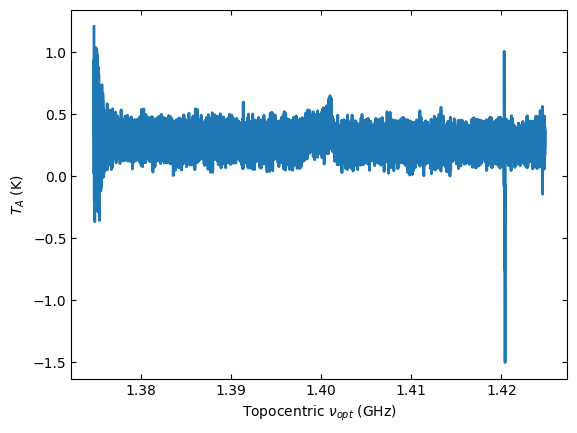

In [8]:
ta.plot(xaxis_unit="GHz")

Change the spectral axis units to km/s and the y-axis to mK, while also showing the spectra between 3600 and 5300 km/s, with the y-axis range between -100 and 1000 mK.

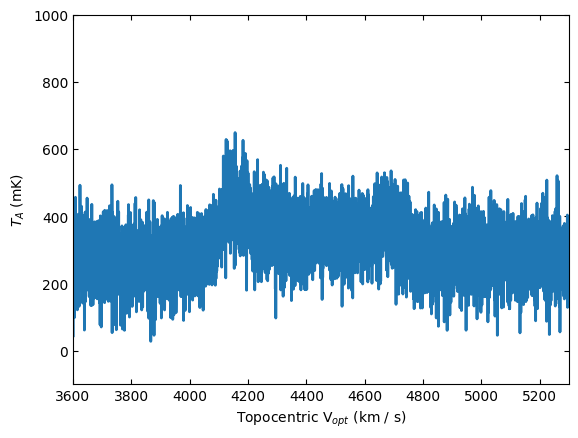

In [9]:
ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-100, ymax=1000, xmin=3600, xmax=5300)

Switch back to GHz as the spectral axis unit.

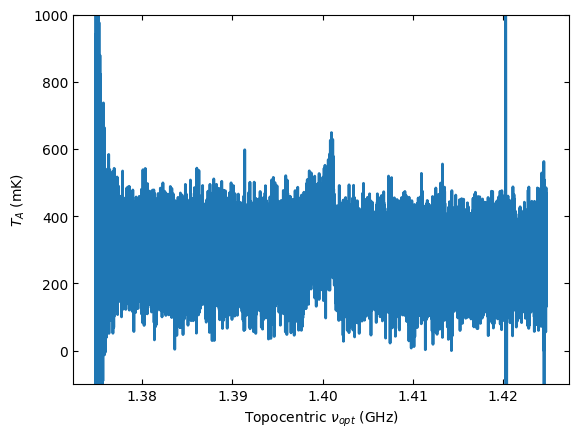

In [10]:
ta.plot(xaxis_unit="GHz", ymin=-100, ymax=1000, yaxis_unit="mK")

## Baseline Subtraction

The following code cells show how to subtract a polynomial baseline from the data. This example uses an order 2 polynomial, and excludes the regions between 3800 and 5000 km/s, where a line is detected. The use of `remove=True` will remove the best fit baseline model from the spectrum.

In [11]:
kms = u.km/u.s
ta.baseline(degree=2, exclude=[3800*kms,5000*kms], remove=True)

EXCLUDING [Spectral Region, 1 sub-regions:
  (1397103816.4779327 Hz, 1402626103.134255 Hz) 
]


 [astropy.modeling.fitting]


When we plot the spectrum again, it has been baseline subtracted.

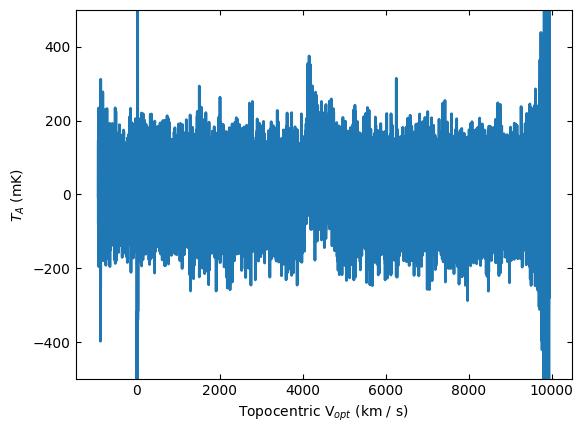

In [12]:
ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-500, ymax=500)

We can inspect the best fit baseline coefficients.

In [13]:
print(ta.baseline_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                   c1                    c2         
            K                  K / Hz               K / Hz2       
    ------------------ ---------------------- --------------------
    1.6463452183080192 -9.793516886548451e-10 -7.1325412756222e-37


And save the figure.

In [14]:
ta.savefig("baselined_removed.png")

---

## Calibration Using Selection

The following code shows how to calibrate scan 51 using selection. At this time selection does not know about signal and reference scan pairs, so the selection must include both scans, otherwise the calibration will fail.

In [15]:
sdfits.select(scan=[51,52], ifnum=0)
sdfits.selection.show()

 ID    TAG      SCAN   IFNUM # SELECTED
--- --------- -------- ----- ----------
  0 2c4cf7b1b [51, 52]     0         88


In [16]:
sb = sdfits.getps(plnum=0)

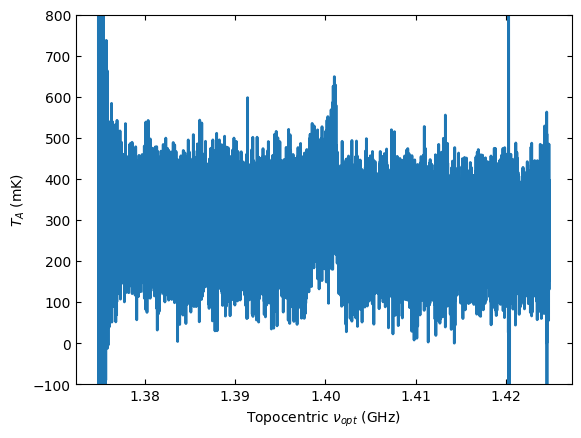

In [18]:
ta2 = sb.timeaverage(weights='tsys')
ta2.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK")

We can calibrate the other polarization, with the scan numbers already selected.

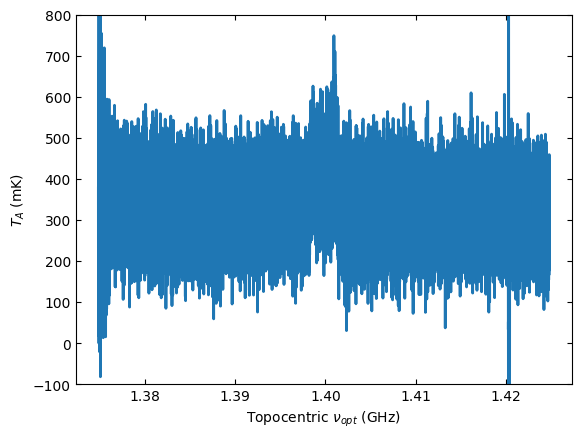

In [19]:
sb = sdfits.getps(plnum=1)
ta3 = sb.timeaverage(weights='tsys')
ta3.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK")

### Polarization Average
Average the polarizations and plot the result.

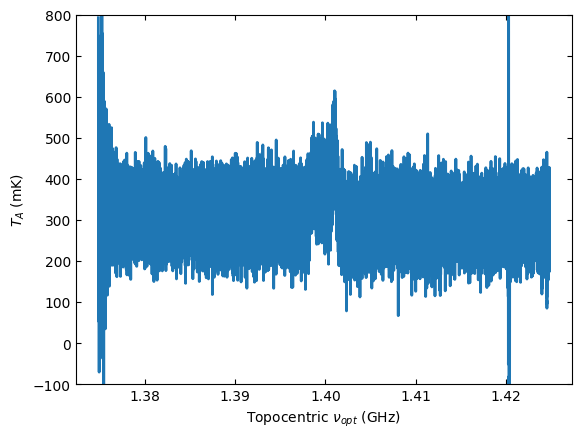

In [20]:
avg = ta2 + ta3
avg *= 0.5
avg.plot(ymin=-100, ymax=800, yaxis_unit="mK", xaxis_unit="GHz")

## Getting the Data Out of `dysh`

So far we have been able to calibrate, baseline subtract and plot the data using the `dysh` objects and functions. However, you can also take the data out of `dysh`. First we will take advantage of `dysh` ability to calibrate all of the position switched data and then extract the calibrated data into `numpy` arrays.

When using `getps` without specifying a scan, `dysh` will try to calibrate all of the position switched data loaded. For this to work, we must clear the selection first.

In [25]:
sdfits.selection.remove(id=0)
sdfits.selection.show()

 ID TAG SCAN IFNUM # SELECTED
--- --- ---- ----- ----------


Calibrate all the scans for the first spectral window and polarization, and then remove a baseline. We use the same parameters as before to have a one-to-one comparison.

In [30]:
ps_scan_block_0 = sdfits.getps(ifnum=0, plnum=0)
ps_ta_0 = ps_scan_block_0.timeaverage(weights='tsys')
ps_ta_0.baseline(degree=2, exclude=[3800*kms,5000*kms], remove=True)

EXCLUDING [Spectral Region, 1 sub-regions:
  (1397103816.4779327 Hz, 1402626103.134255 Hz) 
]


 [astropy.modeling.fitting]


Now plot and compare.

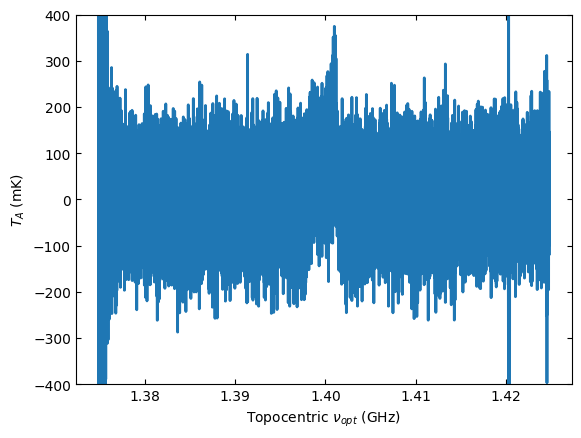

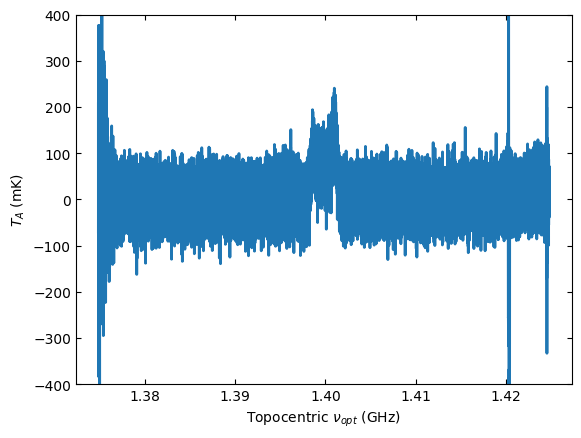

In [33]:
ta.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")
ps_ta_0.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")

The rms in the second Figure is almost half that of the first Figure. That is because there are four pairs of position switched scans in the data, so that results in a factor of $\sqrt4$ reduced noise when we average all the data.

Now lets get the data into numpy arrays.

In [36]:
flux = ps_ta_0.flux.to("K").value
freq = ps_ta_0.spectral_axis.to("GHz").value

We can plot the flux and spectral axis using matplotlib, or save them into a text file.

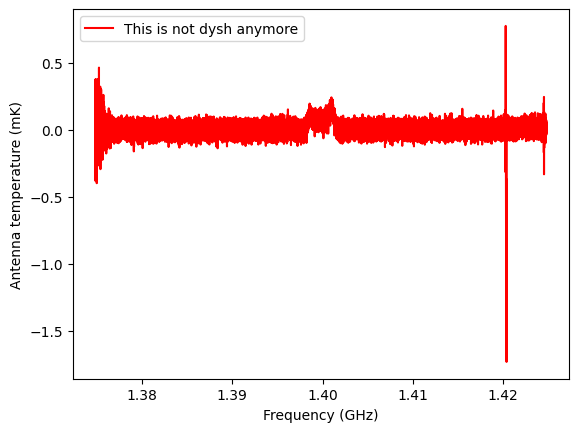

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(freq, flux, "r-", label="This is not dysh anymore")
plt.legend()
plt.xlabel("Frequency (GHz)")
plt.ylabel("Antenna temperature (mK)");

np.savetxt("my_data.txt", np.c_[freq, flux], header="Frequency(GHz) AntennaTemperature(mK)")